**Import all the librairies and functions**

In [1]:
import os
import sys
import importlib
import json
from dataclasses import dataclass, field, fields
from itertools import compress
import csv
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from scipy import signal
import openpyxl
from openpyxl import Workbook, load_workbook
import xlrd
#MNE
import mne
from mne.time_frequency import tfr_morlet
from importlib import reload 
from os.path import join, dirname, realpath, exists

#load poly5reader
# define current working directory (the one that contains this notebook): this is the project_path
os.chdir('c:\\Users\\Juliette\\Research\\Projects\\Synchronization project\\Code\\Synchronization')
project_path = os.getcwd()

# change temporarily the working directory to go fetch the poly5 reader: this is the code_path
os.chdir(os.path.dirname(os.getcwd()))
os.chdir(os.path.join(os.getcwd(), 'tmsi-python-interface-main'))
code_path = os.getcwd()

print (f'working dir for analysis:{project_path}')
print (f'working dir to go fetch Poly5 reader:{code_path}')

#fetch the poly5 reader
from TMSiFileFormats.file_readers import Poly5Reader

# set the working directory back to the project_path
os.chdir(project_path)

# load pyPerceive functions
os.chdir('c:\\Users\\Juliette\\Research\\Projects\\Synchronization project\\Code\\Synchronization')
project_path = os.getcwd()
os.chdir(os.path.dirname(os.getcwd()))
os.chdir(os.path.join(os.getcwd(), 'PyPerceive'))
os.chdir(os.path.join(os.getcwd(), 'code'))
code_path = os.getcwd()
print (f'working dir for analysis:{project_path}')
print (f'working dir to go fetch PyPerceive functions:{code_path}')

from PerceiveImport.classes import (
    main_class, modality_class, metadata_class,
    session_class, condition_class, task_class,
    contact_class, run_class
)
import PerceiveImport.methods.load_rawfile as load_rawfile
import PerceiveImport.methods.find_folders as find_folders
import PerceiveImport.methods.metadata_helpers as metaHelpers

#reset the proper working directory for the analysis
os.chdir(project_path)

working dir for analysis:c:\Users\Juliette\Research\Projects\Synchronization project\Code\Synchronization
working dir to go fetch Poly5 reader:c:\Users\Juliette\Research\Projects\Synchronization project\Code\tmsi-python-interface-main
working dir for analysis:c:\Users\Juliette\Research\Projects\Synchronization project\Code\Synchronization
working dir to go fetch PyPerceive functions:c:\Users\Juliette\Research\Projects\Synchronization project\Code\PyPerceive\code


**Open LFP data**

if PyPerceive:

In [ ]:
# define an example instance and fill in the values of the dataclass PerceiveData 
# choose the values you are interested in analyzing further

sub061 = main_class.PerceiveData(
    sub = "061", 
    incl_modalities=['survey', 'streaming'],
    incl_session = ['postop', 'fu12m', 'fu18m'],
    incl_condition =['m0s0', ],
    incl_task = ["rest"],
    incl_contact = ["RingL", "SegmInterR", "SegmIntraR"],
    import_json=False,
    warn_for_metaNaNs=True,
    # use_bids=True,  # TODO: add to functionality
)

#store the MNE object in the variable
sub061_data = sub061.streaming.postop.m0s0.rest.run1.data
#look at the MNE object
sub061_data

without pyPerceive:

Example with sub-033 18MFU M1S0:

In [2]:
datapath = 'C:\\Users\\Juliette\\OneDrive - Charité - Universitätsmedizin Berlin\\Recordings\\PERCEPT\\sub-033\\18MFU\\MedON\\sub-20210902PStn\\ses-2023020101261271\\ieeg'
filename = 'sub-20210902PStn_ses-2023020101261271_run-BrainSense20230201014600.mat'
data = mne.io.read_raw_fieldtrip(        
	os.path.join(datapath, filename),        
	info={}, # add info here        
	data_name='data',  # name of heading dict/ variable of original MATLAB object    
)
data.ch_names
n_chan = len(data.ch_names)
data.n_times #number of samples
data.times #timepoints set to zero
data._data # channel trials
data.info['sfreq'] # sampling frequency
time_duration = (data.n_times/data.info['sfreq']).astype(float)
time_duration_ms=time_duration*1000
print(     
	f'The data object has:\n\t{data.n_times} time samples,'      
	f'\n\tand a sample frequency of {data.info["sfreq"]} Hz'      
	f'\n\twith a recording duration of {time_duration} seconds.'      
	f'\n\t{n_chan} channels were labeled as \n{data.ch_names}.')


Creating RawArray with float64 data, n_channels=6, n_times=47313
    Range : 0 ... 47312 =      0.000 ...   189.248 secs
Ready.


c:\Users\Juliette\anaconda3\envs\mne\lib\site-packages\pymatreader\utils.py:230: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '
C:\Users\Juliette\AppData\Local\Temp\ipykernel_13584\1936661298.py:3: RuntimeWarning: The supplied FieldTrip structure does not have an elec or grad field. No channel locations will extracted and the kind of channel might be inaccurate.
  data = mne.io.read_raw_fieldtrip(
C:\Users\Juliette\AppData\Local\Temp\ipykernel_13584\1936661298.py:3: RuntimeWarning: Cannot guess the correct type of channel LFP_Stn_L_13. Making it a MISC channel.
  data = mne.io.read_raw_fieldtrip(
C:\Users\Juliette\AppData\Local\Temp\ipykernel_13584\1936661298.py:3: RuntimeWarning: Cannot guess the correct type of channel LFP_Stn_R_13. Making it a MISC channel.
  data = mne.io.read_raw_fieldtrip(
C:\Users\Juliette\AppData\Local\Temp\ipykernel_13

The data object has:
	47313 time samples,
	and a sample frequency of 250.0 Hz
	with a recording duration of 189.252 seconds.
	6 channels were labeled as 
['LFP_Stn_L_13', 'LFP_Stn_R_13', 'LFP_Stn_L_13_PEAK23Hz_THR20-30_AVG3000ms', 'LFP_Stn_R_13_PEAK23Hz_THR20-30_AVG3000ms', 'STIM_L_125Hz_60us', 'STIM_R_125Hz_60us'].


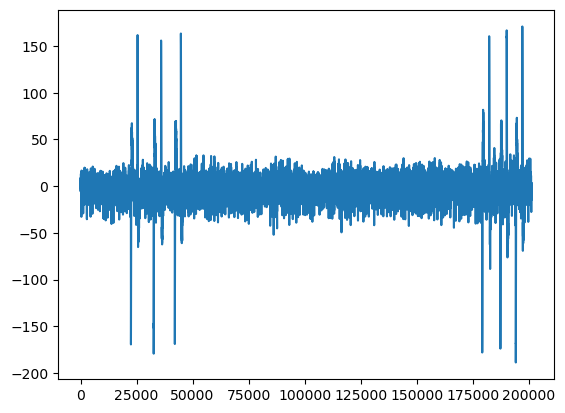

In [116]:
LFP_Stn_L_13 = data.get_data()[0]
x_time=np.arange(0,time_duration_ms,time_duration_ms/data.n_times)
df_LFP=pd.DataFrame(x_time,LFP_Stn_L_13)
plt.plot(x_time,LFP_Stn_L_13)


In [89]:
artefact_time_LFP = 0
i = 0
for i in range(0,len(LFP_Stn_L_13)-1):
    if (LFP_Stn_L_13[i] <= -50):
        artefact_time_LFP = x_time[i]
    else:
        i = i+1
print(f'the artefact in the LFP starts at \n\t{artefact_time_LFP} ms')

the artefact in the LFP starts at 
	185896.0 ms


**Open sensor-data**

In [96]:
TMSi_data = Poly5Reader()

# Extract the samples and channel names from the Poly5Reader object
samples = TMSi_data.samples
ch_names = TMSi_data.ch_names

# Conversion to MNE raw array

toMNE = True
mne_object = TMSi_data.read_data_MNE()

# Retrieve the MNE RawArray info and sample data
info_mne = mne_object.info
samples_mne = mne_object._data
    
#mne_object.plot(start = 5, duration = 5, n_channels = 2) #(only if I want to plot in interactive viewer)

n_chan = len(mne_object.ch_names)
time_duration = (mne_object.n_times/mne_object.info['sfreq']).astype(float)
time_duration_ms=time_duration*1000

print(     
	f'The data object has:\n\t{mne_object.n_times} time samples,'      
	f'\n\tand a sample frequency of {mne_object.info["sfreq"]} Hz'      
	f'\n\twith a recording duration of {time_duration} seconds.'      
	f'\n\t{n_chan} channels were labeled as \n{mne_object.ch_names}.')

x_time=np.arange(0,time_duration_ms,time_duration_ms/mne_object.n_times)




Reading file  C:/Users/Juliette/OneDrive - Charité - Universitätsmedizin Berlin/Recordings/TMSi files/sub-033/18MFU/MedON/Sub_033_18MFU_M1S0_BrStr_Rest - 20230201T144535/Sub_033_18MFU_M1S0_BrStr_Rest-20230201T144535.DATA.Poly5
	 Number of samples:  823856 
	 Number of channels:  12 
	 Sample rate: 4096 Hz
Done reading data.
Creating RawArray with float64 data, n_channels=12, n_times=823856
    Range : 0 ... 823855 =      0.000 ...   201.136 secs
Ready.


c:\Users\Juliette\Research\Projects\Synchronization project\Code\tmsi-python-interface-main\TMSiFileFormats\file_readers\poly5reader.py:92: RuntimeWarning: Channel names are not unique, found duplicates for: {'Y', 'Z', 'X'}. Applying running numbers for duplicates.
  info = mne.create_info(ch_names=labels, sfreq=fs, ch_types=types_clean)


Using qt as 2D backend.
The data object has:
	823856 time samples,
	and a sample frequency of 4096.0 Hz
	with a recording duration of 201.13671875 seconds.
	12 channels were labeled as 
['BIP 01', 'BIP 02', 'BIP 03', 'BIP 04', 'X-0', 'Y-0', 'Z-0', 'X-1', 'Y-1', 'Z-1', 'STATUS', 'Counter 2power24'].


Channels marked as bad:
none


In [110]:
mne_object.plot(start = 5, duration = 5, n_channels = 2)

Channels marked as bad:
none


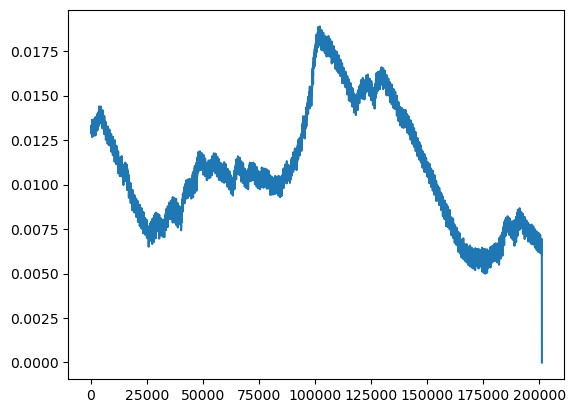

In [111]:
BIP03 = mne_object.get_data()[2]
df_TMSi=pd.DataFrame(x_time,BIP03)
plt.plot(x_time,BIP03)

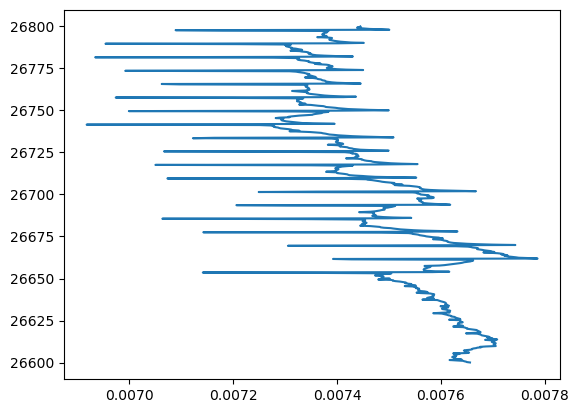

In [112]:
xmin=26.6*1000
xmax=26.8*1000
df_filtered=df_TMSi.loc[(df_TMSi[0] > xmin) & (df_TMSi[0] < xmax)]
df_filtered
plt.plot(df_filtered)


In [113]:
artefact_time_TMSi = 0
i = 0
for i in range(0,len(BIP03)-1):
    if (BIP03[i] <= 0.0074):
        artefact_time_TMSi = x_time[i]
    else:
        i = i+1
print(f'the artefact in the TMSi starts at \n\t{artefact_time_TMSi} ms')

the artefact in the TMSi starts at 
	201136.23046875 ms


**The timing of the artefact has now been found in each recording, we can try to align**